In [1]:
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from estimagic.differentiation.derivatives import first_derivative

sns.set_style("whitegrid")

### Code to integrate

In [2]:
def _convert_jac_candidates_to_frame(jac_candidates, error_candidates):
    """Convert jacobian candidates to data frame.

    Assumes ``n_steps`` > 1.

    Args:
        jac_candidates (dict): Dict with jac candidates.

    Returns:
        df (pd.DataFrame): Frame with column "value" and index
            ["method", "dim_x", "dim_f"] with respective meaning: type
            of method used, e.g. central or foward;
            kind of value, e.g. derivative or error.

    """
    dim_f, dim_x = jac_candidates["forward1"].shape
    x_index = range(dim_x)
    f_index = range(dim_f)

    dfs = []
    for key, value in jac_candidates.items():
        df = pd.DataFrame(value.T, columns=f_index)
        df = df.assign(**{"dim_x": x_index})
        df = df.melt(id_vars="dim_x", var_name="dim_f", value_name="deriv")
        df = df.assign(**{"method": key, "error": error_candidates[key].flatten()})
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.set_index(["method", "dim_x", "dim_f"])
    return df

In [97]:
def visualize_derivative(consolidated_der, df_evals, df_deriv, func_value, dim_x=None, dim_f=None, height=6, width=6):
    """Plot evaluations and derivative estimates.
    
    Args:
        df_evals (pd.DataFrame): Frame containing func evaluations (long-format).
        df_deriv (pd.DataFrame): Frame containing derivative estimates (long-format).
        func_value (np.ndarray): Func value at original params vector.
        dim_x (iterable): Input dimension to consider. Default None, which selects all.
        dim_f (iterable): Output dimensions to consider. Default None, which selects all.
        height (float): Height of represenative plot in grid.
        width (float): Width of representative plot in grid.
        
    Returns:
        grid (sns.FacetGrid): Plot.
        
    """
    def _get_der(df, method, dim_x, dim_f):
        """Quick access to derivative and error entry."""
        df = df.query("method == @method & dim_x == @dim_x & dim_f == @dim_f")
        values = df.reset_index(level=["method", "dim_x", "dim_f"], drop=True).T[0]
        return values
    
    def _min_max_scaler(x):
        diff = x.max() - x.min()
        if diff > 0 and x.name != "deriv":
            return (x - x.min()) / diff
        else:
            return x

        
    func_value = np.atleast_1d(func_value)
    consolidated_der = np.atleast_2d(consolidated_der)
        
    df_deriv = df_deriv.copy()
    df_deriv = df_deriv.groupby(["dim_x", "dim_f"]).transform(_min_max_scaler)
    df_deriv = df_deriv.assign(**{"alpha": 1 - df_deriv["error"]})

    df = df_evals.copy().reset_index()
    df = df.assign(**{"step": df.step * df.sign})
    
    dimensions = df[["dim_x", "dim_f"]].max()
    dim_x = dim_x if dim_x is not None else range(dimensions["dim_x"] + 1)
    dim_f = dim_f if dim_f is not None else range(dimensions["dim_f"] + 1)
    df = df.query("dim_x in @dim_x & dim_f in @dim_f")

    max_steps = df.groupby("dim_x")["step"].max()

    grid = sns.FacetGrid(df, row="dim_x", col="dim_f", sharey=False, sharex=False, height=height, aspect=width/height)
    grid.map(sns.scatterplot, "step", "eval", color="black", zorder=2)
    grid.set_titles(template="dim_x, dim_f = {row_name}, {col_name}")
    grid.set_axis_labels("Param Value", "Func Value")

    for row, col in itertools.product(dim_x, dim_f):
        ax = grid.axes[row, col]
        _x = np.linspace(-max_steps[row], max_steps[row], 100)
        for method in df_deriv.index.get_level_values("method").unique():
            der = _get_der(df_deriv, method, row, col)
            _y = _x * der["deriv"] + func_value[col]
            ax.plot(_x, _y, alpha=der["alpha"], label=method, zorder=1)
        if (row, col) == (0, 0):
            ax.legend(loc='upper center', bbox_to_anchor=(1, 1.25), ncol=3)
        _y = _x * consolidated_der[col][row] + func_value[col]
        ax.plot(_x, _y, color="black", zorder=3)
            
    return grid

### Example

In [86]:
def func(x):
    y1 = x[0] ** 2
    y2 = x[1] ** 3 + x[0]
    return np.array([y1, y2])
    
params = np.zeros(3)

In [87]:
n_steps, dim_x, dim_f = 5, len(params), len(np.atleast_1d(func(params)))

der, info, candidates, cand, err = first_derivative(
    func, params, n_steps=n_steps, return_func_value=True, return_evals=True
)

func_value = info["func_value"]
df_evals = info["df_evals"]

In [88]:
df_deriv = _convert_jac_candidates_to_frame(cand, err)

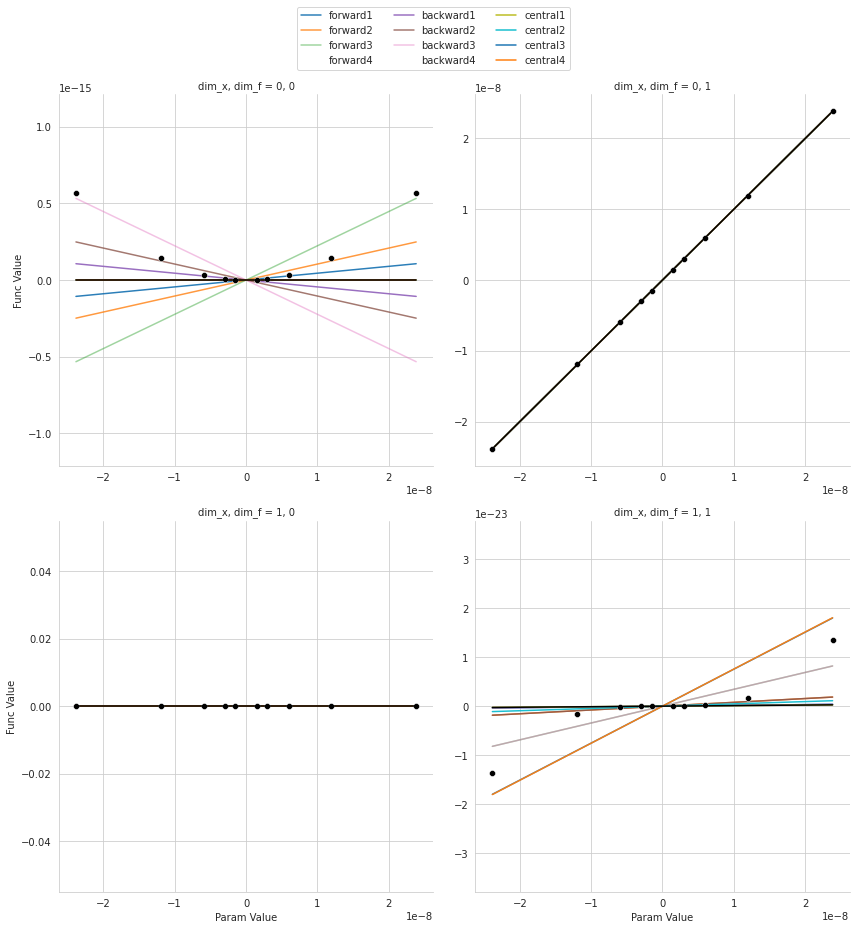

In [98]:
visualize_derivative(der, df_evals, df_deriv, func_value, dim_x=[0, 1])